In [1]:
# =========================
# 0) Imports & config
# =========================
import os, math, random, json
from typing import List, Tuple
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler
from tqdm import tqdm

try:
    from torchvision.transforms import v2 as T
    _HAS_V2 = True
except:
    import torchvision.transforms as T
    _HAS_V2 = False

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

# ---- Paths ----
TRAIN_DIR = "D:/dataset/npz_80_tiny"                    # 210 tiny patients (80 frames)
VAL_DIR   = "D:/dataset/converted_classifier_npz_compact" # 300 compact patients (840 frames)
SAVE_DIR  = "D:/acouslic-ai-cse4622/saved_weights"
os.makedirs(SAVE_DIR, exist_ok=True)

# Dev45 (for CV pool) & Final Test45 (held-out)
DEV45_SLICE   = (210, 255)  # [210:255] → 45 patients
TEST45_SLICE  = (255, 300)  # [255:300] → 45 patients

# ---- Training hyperparams ----
IMAGE_SIZE   = 224
BATCH_SIZE   = 32
VAL_BATCH    = 64
EPOCHS       = 20
PATIENCE     = 5
LR_HEAD      = 1e-3
LR_ALL       = 1e-4
WEIGHT_DEC   = 1e-4
SEED         = 42
K_FOLDS      = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True


In [2]:
# =========================
# 1) Utils: letterbox + dataset
# =========================
def _letterbox_to_square(x: torch.Tensor, size: int = 224) -> torch.Tensor:
    """x: (B,1,H,W) or (1,H,W) in [0,1] → square pad → resize to (..,1,size,size)"""
    is_batched = (x.dim() == 4)
    if not is_batched:
        x = x.unsqueeze(0)  # (1,1,H,W)
    _, _, H, W = x.shape
    s = max(H, W)
    pad_h = (s - H) // 2
    pad_w = (s - W) // 2
    x = F.pad(x, (pad_w, s - W - pad_w, pad_h, s - H - pad_h))  # L,R,T,B
    x = F.interpolate(x, size=(size, size), mode="bilinear", align_corners=False)
    return x if is_batched else x.squeeze(0)

class PreloadedNPZFrameDataset(Dataset):
    """
    Loads all frames from a list of NPZ files in one dir into RAM.
    - Converts to grayscale tensor in [-1,1]
    - Stores per-frame patient_ids (from npz['uuid'] if present, else filename stem)
    """
    def __init__(self, npz_dir: str, files: List[str], binary: bool = True,
                 out_size: int = 224, resize_mode: str = "letterbox",
                 dtype: torch.dtype = torch.float16):
        self.binary = binary
        self.out_size = out_size
        self.resize_mode = resize_mode
        self.dtype = dtype

        imgs_all, labels_all, pids_all = [], [], []

        for f in files:
            path = os.path.join(npz_dir, f)
            case = np.load(path, allow_pickle=True)
            imgs = case["image"]                    # (T,H,W) uint8
            y    = case["label"].astype(np.int64)   # (T,)
            if binary:
                y[y == 2] = 1

            pid = str(case["uuid"]) if "uuid" in case else os.path.splitext(f)[0]
            tframes = imgs.shape[0]
            pids_all.append(torch.full((tframes,), hash(pid) & 0x7fffffff, dtype=torch.int64))

            t = torch.from_numpy(imgs).unsqueeze(1).float() / 255.0  # (T,1,H,W) [0,1]
            if resize_mode == "letterbox":
                out_frames = [ _letterbox_to_square(fr, size=out_size) for fr in t ]
                t = torch.stack(out_frames, dim=0)  # (T,1,S,S)
            else:
                t = F.interpolate(t, size=(out_size, out_size), mode="bilinear", align_corners=False)

            t = (t - 0.5) / 0.5  # [-1,1]
            imgs_all.append(t.to(dtype=dtype).cpu())
            labels_all.append(torch.from_numpy(y).long())

        self.images      = torch.cat(imgs_all, dim=0)            # (N,1,S,S)
        self.labels      = torch.cat(labels_all, dim=0)          # (N,)
        self.patient_ids = torch.cat(pids_all, dim=0)            # (N,)

    def __len__(self): return self.labels.numel()
    def __getitem__(self, idx): return self.images[idx], self.labels[idx]


In [3]:
# =========================
# 2) Safe transforms + wrapper
# =========================
class AddGaussianNoise(nn.Module):
    def __init__(self, std=0.03): super().__init__(); self.std=float(std)
    def forward(self, x): return x + torch.randn_like(x)*self.std if self.std>0 else x

# train-time augs (operate on tensors already in [-1,1])
train_tf = T.Compose([
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.1),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.08, 0.08), scale=(0.9, 1.1)),
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    T.RandomApply([AddGaussianNoise(0.03)], p=0.2),
])

# validation: true no-op
val_tf = T.Compose([T.Identity()]) if _HAS_V2 else T.Compose([T.RandomApply([], p=0.0)])

class WithTransform(Dataset):
    def __init__(self, base: Dataset, transform=None):
        self.base = base
        self.transform = transform
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        x = x.to(torch.float32)
        if self.transform is not None:
            x = self.transform(x)
        return x, y


In [4]:
# =========================
# 3) Patient-aware balanced sampler
# =========================
class PatientAwareBalancedBatchSampler(Sampler):
    """
    50/50 pos/neg batches that also mix patients.
    """
    def __init__(self, labels, patient_ids, batch_size=32, frames_per_patient_side=2, pos_label=1, seed=42):
        assert batch_size % 2 == 0 and batch_size >= 2
        self.labels = list(map(int, labels))
        self.pids   = list(map(int, patient_ids))
        self.half   = batch_size // 2
        self.k      = max(1, int(frames_per_patient_side))
        self.pos_label = pos_label
        self.rng = random.Random(seed)

        pos_by_pid = defaultdict(list)
        neg_by_pid = defaultdict(list)
        for i, (y, pid) in enumerate(zip(self.labels, self.pids)):
            if y == pos_label: pos_by_pid[pid].append(i)
            elif y == 0:       neg_by_pid[pid].append(i)

        if not pos_by_pid or not neg_by_pid:
            raise ValueError("Need patients with both pos and neg frames.")

        self.pos_by_pid = {pid: idxs for pid, idxs in pos_by_pid.items() if idxs}
        self.neg_by_pid = {pid: idxs for pid, idxs in neg_by_pid.items() if idxs}
        self.pos_patients = list(self.pos_by_pid.keys())
        self.neg_patients = list(self.neg_by_pid.keys())

        self.num_pos = sum(len(v) for v in self.pos_by_pid.values())
        self.steps   = math.ceil(self.num_pos / self.half)

    def __len__(self): return self.steps

    def _multi_patient_take(self, pools_by_pid, patient_ids, need):
        rng = self.rng
        out = []
        active = {pid: rng.sample(idxs, k=len(idxs)) for pid, idxs in pools_by_pid.items()}
        ring = patient_ids[:]
        rng.shuffle(ring)
        head = 0
        while len(out) < need:
            if head >= len(ring):
                head = 0
                rng.shuffle(ring)
            pid = ring[head]; head += 1
            pool = active.get(pid, [])
            if not pool: continue
            take = min(self.k, len(pool), need - len(out))
            out.extend(pool[:take])
            active[pid] = pool[take:]
            if all(len(v) == 0 for v in active.values()):
                active = {pid: rng.sample(pools_by_pid[pid], k=len(pools_by_pid[pid])) for pid in pools_by_pid}
        return out

    def __iter__(self):
        rng = self.rng
        all_pos = []
        for pid, idxs in self.pos_by_pid.items():
            all_pos.extend(idxs)
        rng.shuffle(all_pos)

        total_pos_needed = self.steps * self.half
        if len(all_pos) < total_pos_needed:
            reps = math.ceil(total_pos_needed / len(all_pos))
            all_pos = (all_pos * reps)[:total_pos_needed]
        else:
            all_pos = all_pos[:total_pos_needed]

        pos_cursor = 0
        for _ in range(self.steps):
            pos_slice = all_pos[pos_cursor: pos_cursor + self.half]
            pos_cursor += self.half
            by_pid = defaultdict(list)
            for i in pos_slice:
                by_pid[self.pids[i]].append(i)

            p_batch = []
            pids_shuf = list(by_pid.keys())
            rng.shuffle(pids_shuf)
            for pid in pids_shuf:
                take = min(self.k, len(by_pid[pid]), self.half - len(p_batch))
                if take > 0: p_batch.extend(by_pid[pid][:take])
                if len(p_batch) == self.half: break
            if len(p_batch) < self.half:
                extras = []
                for pid in pids_shuf:
                    extras.extend(by_pid[pid][self.k:])
                p_batch = (p_batch + extras)[:self.half]

            n_batch = self._multi_patient_take(self.neg_by_pid, self.neg_patients, self.half)
            batch = p_batch + n_batch
            rng.shuffle(batch)
            yield batch


In [5]:
# =========================
# 4) Model (ResNet50 1ch)
# =========================
import torchvision.models as models

class FrameClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        try:
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        except:
            backbone = models.resnet50(pretrained=True)

        old = backbone.conv1
        new = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            new.weight.copy_(old.weight.mean(dim=1, keepdim=True))
        backbone.conv1 = new

        backbone.fc = nn.Linear(backbone.fc.in_features, num_classes)
        self.backbone = backbone

    def forward(self, x): return self.backbone(x)


In [6]:
# =========================
# 5) SimSiam pretrain (once) on CV pool (255 patients)
# =========================
class TwoCropsTransform(nn.Module):
    def __init__(self, base): super().__init__(); self.base = base
    def forward(self, x):
        v1 = self.base(x); v2 = self.base(x)
        return v1, v2

class SSLPairDataset(Dataset):
    def __init__(self, base: Dataset, transform):
        self.base = base; self.transform = transform
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x, _ = self.base[idx]
        x = x.to(torch.float32)
        v1, v2 = self.transform(x)
        return v1, v2

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=2048, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim, bias=True),
        )
    def forward(self, x): return self.net(x)

class Predictor(nn.Module):
    def __init__(self, in_dim=256, hidden=256, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x): return self.net(x)

class SimSiamResNet(nn.Module):
    def __init__(self, start_from_imagenet=True):
        super().__init__()
        try:
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if start_from_imagenet else None)
        except:
            backbone = models.resnet50(pretrained=start_from_imagenet)
        old = backbone.conv1
        new = nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False)
        with torch.no_grad():
            if old.weight.shape[1]==3:
                new.weight.copy_(old.weight.mean(dim=1, keepdim=True))
            else:
                nn.init.kaiming_normal_(new.weight, mode="fan_out", nonlinearity="relu")
        backbone.conv1 = new
        feat_dim = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.encoder   = backbone
        self.projector = MLP(feat_dim, 2048, 256)
        self.predictor = Predictor(256, 256, 256)

    def forward(self, x1, x2):
        f1 = self.encoder(x1); f2 = self.encoder(x2)
        z1 = self.projector(f1); z2 = self.projector(f2)
        p1 = self.predictor(z1); p2 = self.predictor(z2)
        return p1, z1.detach(), p2, z2.detach()

def neg_cos_sim(p, z):
    p = F.normalize(p, dim=1); z = F.normalize(z, dim=1)
    return - (p * z).sum(dim=1).mean()

# SSL transforms
ssl_base_aug = T.Compose([
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.1),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.08,0.08), scale=(0.9,1.1)),
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1,1.0))], p=0.2),
    T.RandomApply([AddGaussianNoise(0.03)], p=0.2),
])
ssl_transform = TwoCropsTransform(ssl_base_aug)


In [7]:
# =========================
# 6) Build CV pool (Option A) + SSL pretrain once
# =========================
def list_cv_pool_and_test(train_dir, val_dir, dev_slice=(210,255), test_slice=(255,300)):
    # 210 tiny train
    tiny_files = sorted([f for f in os.listdir(train_dir) if f.endswith(".npz")])[:210]
    # 45 compact dev
    dev_files  = sorted([f for f in os.listdir(val_dir)   if f.endswith(".npz")])[dev_slice[0]:dev_slice[1]]
    # 45 compact test (held out)
    test_files = sorted([f for f in os.listdir(val_dir)   if f.endswith(".npz")])[test_slice[0]:test_slice[1]]

    # CV pool records with has_pos label
    pool = []
    for f in tiny_files:
        y = np.load(os.path.join(train_dir, f), mmap_mode="r")["label"].astype(np.int64)
        has_pos = np.any((y == 1) | (y == 2))
        pool.append({"dir": train_dir, "file": f, "has_pos": int(has_pos)})

    for f in dev_files:
        y = np.load(os.path.join(val_dir, f), mmap_mode="r")["label"].astype(np.int64)
        has_pos = np.any((y == 1) | (y == 2))
        pool.append({"dir": val_dir, "file": f, "has_pos": int(has_pos)})

    test_paths = [os.path.join(val_dir, f) for f in test_files]
    return pool, test_paths

CV_POOL, TEST_PATHS = list_cv_pool_and_test(TRAIN_DIR, VAL_DIR, DEV45_SLICE, TEST45_SLICE)
print(f"[CV POOL] {len(CV_POOL)} patients (210 tiny + 45 compact)")
print(f"[TEST]   {len(TEST_PATHS)} patients (held-out)")

# ---- SSL pretrain once on entire CV pool unlabeled ----
# Build unlabeled base by concatenating two Preloaded datasets (one per dir subset)
tiny_files_for_ssl   = [r["file"] for r in CV_POOL if r["dir"] == TRAIN_DIR]
dev45_files_for_ssl  = [r["file"] for r in CV_POOL if r["dir"] == VAL_DIR]

ssl_base_tiny = PreloadedNPZFrameDataset(TRAIN_DIR, tiny_files_for_ssl, binary=True, out_size=IMAGE_SIZE)
ssl_base_dev  = PreloadedNPZFrameDataset(VAL_DIR,   dev45_files_for_ssl, binary=True, out_size=IMAGE_SIZE)
ssl_base_all  = ConcatDataset([ssl_base_tiny, ssl_base_dev])
ssl_ds        = SSLPairDataset(ssl_base_all, transform=ssl_transform)

SSL_BATCH  = 128
SSL_EPOCHS = 30               # reduce if needed
LR_BASE    = 0.05
SSL_PATIENCE = 5
MIN_DELTA    = 1e-4

ssl_loader = DataLoader(ssl_ds, batch_size=SSL_BATCH, shuffle=True,
                        num_workers=0, pin_memory=True, drop_last=True)  # Windows-safe

simsiam = SimSiamResNet(start_from_imagenet=True).to(device)
opt_ssl = torch.optim.SGD(simsiam.parameters(), lr=LR_BASE, momentum=0.9, weight_decay=WEIGHT_DEC)
sched_ssl = torch.optim.lr_scheduler.CosineAnnealingLR(opt_ssl, T_max=SSL_EPOCHS)
scaler_ssl = amp.GradScaler(enabled=(device=="cuda"))

best_loss = float("inf"); bad = 0; best_epoch_ssl = 0
ENC_BEST = os.path.join(SAVE_DIR, "simsiam_encoder_best_optionA.pth")

for epoch in range(1, SSL_EPOCHS+1):
    simsiam.train()
    running = 0.0; nseen = 0
    pbar = tqdm(ssl_loader, desc=f"[SSL] SimSiam {epoch}/{SSL_EPOCHS}")
    for v1, v2 in pbar:
        v1 = v1.to(device, non_blocking=True).float()
        v2 = v2.to(device, non_blocking=True).float()
        opt_ssl.zero_grad(set_to_none=True)
        with amp.autocast(device_type="cuda", enabled=(device=="cuda")):
            p1, z2, p2, z1 = simsiam(v1, v2)
            loss = 0.5*neg_cos_sim(p1,z2) + 0.5*neg_cos_sim(p2,z1)
        scaler_ssl.scale(loss).backward()
        scaler_ssl.step(opt_ssl)
        scaler_ssl.update()
        running += loss.item() * v1.size(0); nseen += v1.size(0)
        pbar.set_postfix(loss=running/max(1,nseen))
    sched_ssl.step()
    avg = running/max(1,nseen)
    print(f"Epoch {epoch}: SimSiam loss {avg:.4f}")
    if (best_loss - avg) > MIN_DELTA:
        best_loss = avg; bad = 0; best_epoch_ssl = epoch
        torch.save(simsiam.encoder.state_dict(), ENC_BEST)
        print(f"  ✅ Saved best encoder @ epoch {epoch} (loss {best_loss:.4f})")
    else:
        bad += 1
        if bad >= SSL_PATIENCE:
            print("  ⏹ SSL early stopping.")
            break

print(f"[SSL] Best epoch={best_epoch_ssl}, best loss={best_loss:.4f}, saved: {ENC_BEST}")


[CV POOL] 255 patients (210 tiny + 45 compact)
[TEST]   45 patients (held-out)


[SSL] SimSiam 1/30: 100%|██████████| 426/426 [05:39<00:00,  1.26it/s, loss=-0.922]


Epoch 1: SimSiam loss -0.9220
  ✅ Saved best encoder @ epoch 1 (loss -0.9220)


[SSL] SimSiam 2/30: 100%|██████████| 426/426 [05:33<00:00,  1.28it/s, loss=-0.962]


Epoch 2: SimSiam loss -0.9615
  ✅ Saved best encoder @ epoch 2 (loss -0.9615)


[SSL] SimSiam 3/30: 100%|██████████| 426/426 [05:27<00:00,  1.30it/s, loss=-0.968]


Epoch 3: SimSiam loss -0.9682
  ✅ Saved best encoder @ epoch 3 (loss -0.9682)


[SSL] SimSiam 4/30: 100%|██████████| 426/426 [05:31<00:00,  1.29it/s, loss=-0.97] 


Epoch 4: SimSiam loss -0.9700
  ✅ Saved best encoder @ epoch 4 (loss -0.9700)


[SSL] SimSiam 5/30: 100%|██████████| 426/426 [05:35<00:00,  1.27it/s, loss=-0.966]


Epoch 5: SimSiam loss -0.9664


[SSL] SimSiam 6/30: 100%|██████████| 426/426 [05:28<00:00,  1.30it/s, loss=-0.967]


Epoch 6: SimSiam loss -0.9667


[SSL] SimSiam 7/30: 100%|██████████| 426/426 [05:34<00:00,  1.27it/s, loss=-0.975]


Epoch 7: SimSiam loss -0.9753
  ✅ Saved best encoder @ epoch 7 (loss -0.9753)


[SSL] SimSiam 8/30: 100%|██████████| 426/426 [05:30<00:00,  1.29it/s, loss=-0.979]


Epoch 8: SimSiam loss -0.9794
  ✅ Saved best encoder @ epoch 8 (loss -0.9794)


[SSL] SimSiam 9/30: 100%|██████████| 426/426 [05:29<00:00,  1.29it/s, loss=-0.973]


Epoch 9: SimSiam loss -0.9729


[SSL] SimSiam 10/30: 100%|██████████| 426/426 [05:26<00:00,  1.31it/s, loss=-0.98] 


Epoch 10: SimSiam loss -0.9799
  ✅ Saved best encoder @ epoch 10 (loss -0.9799)


[SSL] SimSiam 11/30: 100%|██████████| 426/426 [05:29<00:00,  1.29it/s, loss=-0.98] 


Epoch 11: SimSiam loss -0.9796


[SSL] SimSiam 12/30: 100%|██████████| 426/426 [05:33<00:00,  1.28it/s, loss=-0.971]


Epoch 12: SimSiam loss -0.9712


[SSL] SimSiam 13/30: 100%|██████████| 426/426 [05:30<00:00,  1.29it/s, loss=-0.98] 


Epoch 13: SimSiam loss -0.9805
  ✅ Saved best encoder @ epoch 13 (loss -0.9805)


[SSL] SimSiam 14/30: 100%|██████████| 426/426 [05:37<00:00,  1.26it/s, loss=-0.985]


Epoch 14: SimSiam loss -0.9852
  ✅ Saved best encoder @ epoch 14 (loss -0.9852)


[SSL] SimSiam 15/30: 100%|██████████| 426/426 [05:42<00:00,  1.24it/s, loss=-0.988]


Epoch 15: SimSiam loss -0.9881
  ✅ Saved best encoder @ epoch 15 (loss -0.9881)


[SSL] SimSiam 16/30: 100%|██████████| 426/426 [05:36<00:00,  1.27it/s, loss=-0.992]


Epoch 16: SimSiam loss -0.9921
  ✅ Saved best encoder @ epoch 16 (loss -0.9921)


[SSL] SimSiam 17/30: 100%|██████████| 426/426 [05:39<00:00,  1.26it/s, loss=-0.985]


Epoch 17: SimSiam loss -0.9850


[SSL] SimSiam 18/30: 100%|██████████| 426/426 [05:36<00:00,  1.27it/s, loss=-0.989]


Epoch 18: SimSiam loss -0.9894


[SSL] SimSiam 19/30: 100%|██████████| 426/426 [05:38<00:00,  1.26it/s, loss=-0.991]


Epoch 19: SimSiam loss -0.9906


[SSL] SimSiam 20/30: 100%|██████████| 426/426 [05:39<00:00,  1.26it/s, loss=-0.992]


Epoch 20: SimSiam loss -0.9916


[SSL] SimSiam 21/30: 100%|██████████| 426/426 [05:27<00:00,  1.30it/s, loss=-0.989]

Epoch 21: SimSiam loss -0.9888
  ⏹ SSL early stopping.
[SSL] Best epoch=16, best loss=-0.9921, saved: D:/acouslic-ai-cse4622/saved_weights\simsiam_encoder_best_optionA.pth


In [8]:
# =========================
# 7) Build folds (Option A: 255 patients)
# =========================
def build_optionA_folds(cv_pool, k=5, seed=42):
    y = np.array([rec["has_pos"] for rec in cv_pool], dtype=np.int64)
    idxs = np.arange(len(cv_pool))
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    folds = []
    for fold_id, (tr_idx, va_idx) in enumerate(skf.split(idxs, y), 1):
        tr = [cv_pool[i] for i in tr_idx]
        va = [cv_pool[i] for i in va_idx]

        # Separate by directory (so we can create datasets per dir then concat)
        tr_tiny   = [r["file"] for r in tr if r["dir"] == TRAIN_DIR]
        tr_dev45  = [r["file"] for r in tr if r["dir"] == VAL_DIR]
        va_tiny   = [r["file"] for r in va if r["dir"] == TRAIN_DIR]
        va_dev45  = [r["file"] for r in va if r["dir"] == VAL_DIR]

        folds.append((tr_tiny, tr_dev45, va_tiny, va_dev45))
    return folds

folds = build_optionA_folds(CV_POOL, k=K_FOLDS, seed=SEED)
print(f"[FOLDS] Built {len(folds)} folds from 255 patients.")


[FOLDS] Built 5 folds from 255 patients.


In [9]:
# =========================
# 8) Train one fold
# =========================
@torch.no_grad()
def collect_logits_targets(model, loader):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True).float()
        y = y.to(device, non_blocking=True)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
    return torch.cat(all_logits), torch.cat(all_targets).numpy()

def find_best_threshold(logits, targets, goal="f1", target_precision=None):
    probs = F.softmax(logits, dim=1)[:, 1].numpy()
    y = np.array(targets)
    best_t, best_score = 0.5, -1.0
    for t in np.linspace(0.3, 0.9, 61):
        yhat = (probs >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
        score = (r if (target_precision and p >= target_precision) else f1 if goal == "f1" else p)
        if score > best_score:
            best_score, best_t = score, t
    return best_t

def train_one_fold(fold_id, tr_tiny, tr_dev45, va_tiny, va_dev45, ssl_encoder_path: str):
    print(f"\n========== Fold {fold_id} ==========")
    # Build base datasets
    parts_tr = []
    if len(tr_tiny)>0:  parts_tr.append(PreloadedNPZFrameDataset(TRAIN_DIR, tr_tiny,  binary=True, out_size=IMAGE_SIZE))
    if len(tr_dev45)>0: parts_tr.append(PreloadedNPZFrameDataset(VAL_DIR,   tr_dev45, binary=True, out_size=IMAGE_SIZE))
    base_tr = ConcatDataset(parts_tr) if len(parts_tr)>1 else parts_tr[0]

    parts_va = []
    if len(va_tiny)>0:  parts_va.append(PreloadedNPZFrameDataset(TRAIN_DIR, va_tiny,  binary=True, out_size=IMAGE_SIZE))
    if len(va_dev45)>0: parts_va.append(PreloadedNPZFrameDataset(VAL_DIR,   va_dev45, binary=True, out_size=IMAGE_SIZE))
    base_va = ConcatDataset(parts_va) if len(parts_va)>1 else parts_va[0]

    # Wrap transforms
    train_ds = WithTransform(base_tr, transform=train_tf)
    val_ds   = WithTransform(base_va, transform=val_tf)

    # Combine labels/pids for sampler
    if isinstance(base_tr, ConcatDataset):
        tr_labels = torch.cat([d.labels for d in base_tr.datasets], dim=0)
        tr_pids   = torch.cat([d.patient_ids for d in base_tr.datasets], dim=0)
    else:
        tr_labels = base_tr.labels
        tr_pids   = base_tr.patient_ids

    sampler = PatientAwareBalancedBatchSampler(
        labels=tr_labels.tolist(),
        patient_ids=tr_pids.tolist(),
        batch_size=BATCH_SIZE,
        frames_per_patient_side=2,
        pos_label=1,
        seed=SEED
    )
    train_loader = DataLoader(train_ds, batch_sampler=sampler, num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH, shuffle=False, num_workers=0, pin_memory=True)

    # Model
    model = FrameClassifier(num_classes=2).to(device)
    if os.path.isfile(ssl_encoder_path):
        enc_state = torch.load(ssl_encoder_path, map_location=device)
        missing, unexpected = model.backbone.load_state_dict(enc_state, strict=False)
        print("Loaded SimSiam encoder. missing:", missing, "unexpected:", unexpected)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05).to(device)

    # Head warmup
    for p in model.backbone.parameters(): p.requires_grad = False
    for p in model.backbone.fc.parameters(): p.requires_grad = True
    opt = torch.optim.AdamW(model.backbone.fc.parameters(), lr=LR_HEAD, weight_decay=WEIGHT_DEC)
    scaler = amp.GradScaler(enabled=(device=="cuda"))

    best_metric = -1.0
    bad = 0
    fold_save_path = os.path.join(SAVE_DIR, f"frame_cls_fold{fold_id}.pth")
    best_thr = 0.5

    for epoch in range(1, EPOCHS+1):
        # unfreeze after warmup
        if epoch == 2 and any(not p.requires_grad for p in model.backbone.parameters()):
            for p in model.backbone.parameters(): p.requires_grad = True
            opt = torch.optim.AdamW(model.parameters(), lr=LR_ALL, weight_decay=WEIGHT_DEC)

        model.train()
        running = 0.0; nseen=0
        pbar = tqdm(train_loader, desc=f"[Fold {fold_id}] Train {epoch}/{EPOCHS}")
        for x, y in pbar:
            x = x.to(device, non_blocking=True).float()
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with amp.autocast(device_type="cuda", enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            running += loss.item() * x.size(0); nseen += x.size(0)
            pbar.set_postfix(loss=running/max(1,nseen))

        train_loss = running/max(1,nseen)

        # Validation
        val_logits, val_targets = collect_logits_targets(model, val_loader)
        t_star = find_best_threshold(val_logits, val_targets, goal="f1")
        probs = F.softmax(val_logits, dim=1)[:,1].numpy()
        pred  = (probs >= t_star).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(val_targets, pred, average="binary", zero_division=0)
        acc = (pred == val_targets).mean()

        print(f"  -> train loss {train_loss:.4f} | val acc {acc*100:.2f}% | P/R/F1 {p:.3f}/{r:.3f}/{f1:.3f} | thr* {t_star:.2f}")

        metric = f1
        if metric > best_metric:
            best_metric = metric; bad = 0; best_thr = t_star
            torch.save(model.state_dict(), fold_save_path)
            print(f"  ✅ Saved best (F1={best_metric:.3f} @ thr={best_thr:.2f})")
        else:
            bad += 1
            if bad >= PATIENCE:
                print("  ⏹ Early stopping.")
                break

    return fold_save_path, best_metric, best_thr

# ---- Run all folds ----
fold_summ = []
for i, (tr_tiny, tr_dev45, va_tiny, va_dev45) in enumerate(folds, 1):
    path, f1, thr = train_one_fold(i, tr_tiny, tr_dev45, va_tiny, va_dev45,
                                   ssl_encoder_path=ENC_BEST)
    fold_summ.append((i, f1, thr, path))

print("\n==== K-FOLD SUMMARY ====")
for i, f1, thr, path in fold_summ:
    print(f"Fold {i}: F1={f1:.3f}, thr={thr:.2f}, weights={path}")

best_fold = max(fold_summ, key=lambda t: t[1])
print(f"\nBest fold: {best_fold[0]} | F1={best_fold[1]:.3f} | thr={best_fold[2]:.2f}")
BEST_MODEL_PATH = best_fold[3]
BEST_THRESHOLD  = best_fold[2]



========== Fold 1 ==========
Loaded SimSiam encoder. missing: ['fc.weight', 'fc.bias'] unexpected: []


[Fold 1] Train 1/20: 100%|██████████| 326/326 [00:24<00:00, 13.47it/s, loss=0.545]


  -> train loss 0.5453 | val acc 76.19% | P/R/F1 0.315/0.532/0.396 | thr* 0.69
  ✅ Saved best (F1=0.396 @ thr=0.69)


[Fold 1] Train 2/20: 100%|██████████| 326/326 [00:40<00:00,  7.99it/s, loss=0.424]


  -> train loss 0.4238 | val acc 88.07% | P/R/F1 0.574/0.717/0.638 | thr* 0.87
  ✅ Saved best (F1=0.638 @ thr=0.87)


[Fold 1] Train 3/20: 100%|██████████| 326/326 [00:37<00:00,  8.73it/s, loss=0.327]


  -> train loss 0.3273 | val acc 90.47% | P/R/F1 0.639/0.803/0.712 | thr* 0.77
  ✅ Saved best (F1=0.712 @ thr=0.77)


[Fold 1] Train 4/20: 100%|██████████| 326/326 [00:36<00:00,  8.83it/s, loss=0.277]


  -> train loss 0.2775 | val acc 93.03% | P/R/F1 0.727/0.840/0.779 | thr* 0.66
  ✅ Saved best (F1=0.779 @ thr=0.66)


[Fold 1] Train 5/20: 100%|██████████| 326/326 [00:36<00:00,  8.81it/s, loss=0.247]


  -> train loss 0.2473 | val acc 93.54% | P/R/F1 0.765/0.808/0.786 | thr* 0.74
  ✅ Saved best (F1=0.786 @ thr=0.74)


[Fold 1] Train 6/20: 100%|██████████| 326/326 [00:36<00:00,  8.85it/s, loss=0.233]


  -> train loss 0.2333 | val acc 94.21% | P/R/F1 0.796/0.813/0.805 | thr* 0.84
  ✅ Saved best (F1=0.805 @ thr=0.84)


[Fold 1] Train 7/20: 100%|██████████| 326/326 [00:37<00:00,  8.78it/s, loss=0.228]


  -> train loss 0.2277 | val acc 94.43% | P/R/F1 0.785/0.854/0.818 | thr* 0.82
  ✅ Saved best (F1=0.818 @ thr=0.82)


[Fold 1] Train 8/20: 100%|██████████| 326/326 [00:37<00:00,  8.75it/s, loss=0.222]


  -> train loss 0.2216 | val acc 93.72% | P/R/F1 0.745/0.868/0.802 | thr* 0.39


[Fold 1] Train 9/20: 100%|██████████| 326/326 [00:36<00:00,  8.82it/s, loss=0.206]


  -> train loss 0.2063 | val acc 94.00% | P/R/F1 0.769/0.845/0.805 | thr* 0.80


[Fold 1] Train 10/20: 100%|██████████| 326/326 [00:36<00:00,  8.85it/s, loss=0.203]


  -> train loss 0.2029 | val acc 94.16% | P/R/F1 0.782/0.834/0.807 | thr* 0.76


[Fold 1] Train 11/20: 100%|██████████| 326/326 [00:36<00:00,  8.84it/s, loss=0.204]


  -> train loss 0.2041 | val acc 94.78% | P/R/F1 0.801/0.857/0.828 | thr* 0.77
  ✅ Saved best (F1=0.828 @ thr=0.77)


[Fold 1] Train 12/20: 100%|██████████| 326/326 [00:37<00:00,  8.79it/s, loss=0.198]


  -> train loss 0.1975 | val acc 93.87% | P/R/F1 0.759/0.852/0.803 | thr* 0.38


[Fold 1] Train 13/20: 100%|██████████| 326/326 [00:37<00:00,  8.80it/s, loss=0.194]


  -> train loss 0.1938 | val acc 94.80% | P/R/F1 0.808/0.846/0.827 | thr* 0.50


[Fold 1] Train 14/20: 100%|██████████| 326/326 [00:37<00:00,  8.80it/s, loss=0.195]


  -> train loss 0.1947 | val acc 94.71% | P/R/F1 0.804/0.845/0.824 | thr* 0.69


[Fold 1] Train 15/20: 100%|██████████| 326/326 [00:37<00:00,  8.81it/s, loss=0.185]


  -> train loss 0.1854 | val acc 93.87% | P/R/F1 0.745/0.884/0.809 | thr* 0.45


[Fold 1] Train 16/20: 100%|██████████| 326/326 [00:37<00:00,  8.81it/s, loss=0.182]


  -> train loss 0.1820 | val acc 94.29% | P/R/F1 0.796/0.821/0.808 | thr* 0.85
  ⏹ Early stopping.

========== Fold 2 ==========
Loaded SimSiam encoder. missing: ['fc.weight', 'fc.bias'] unexpected: []


[Fold 2] Train 1/20: 100%|██████████| 317/317 [00:23<00:00, 13.76it/s, loss=0.554]


  -> train loss 0.5543 | val acc 82.23% | P/R/F1 0.381/0.602/0.466 | thr* 0.63
  ✅ Saved best (F1=0.466 @ thr=0.63)


[Fold 2] Train 2/20: 100%|██████████| 317/317 [00:36<00:00,  8.79it/s, loss=0.436]


  -> train loss 0.4357 | val acc 88.23% | P/R/F1 0.531/0.749/0.622 | thr* 0.40
  ✅ Saved best (F1=0.622 @ thr=0.40)


[Fold 2] Train 3/20: 100%|██████████| 317/317 [00:36<00:00,  8.80it/s, loss=0.325]


  -> train loss 0.3250 | val acc 94.05% | P/R/F1 0.751/0.806/0.778 | thr* 0.70
  ✅ Saved best (F1=0.778 @ thr=0.70)


[Fold 2] Train 4/20: 100%|██████████| 317/317 [00:35<00:00,  8.81it/s, loss=0.279]


  -> train loss 0.2795 | val acc 92.99% | P/R/F1 0.694/0.818/0.751 | thr* 0.58


[Fold 2] Train 5/20: 100%|██████████| 317/317 [00:36<00:00,  8.79it/s, loss=0.254]


  -> train loss 0.2544 | val acc 94.71% | P/R/F1 0.751/0.882/0.811 | thr* 0.59
  ✅ Saved best (F1=0.811 @ thr=0.59)


[Fold 2] Train 6/20: 100%|██████████| 317/317 [00:38<00:00,  8.28it/s, loss=0.241]


  -> train loss 0.2409 | val acc 95.64% | P/R/F1 0.811/0.863/0.836 | thr* 0.84
  ✅ Saved best (F1=0.836 @ thr=0.84)


[Fold 2] Train 7/20: 100%|██████████| 317/317 [00:37<00:00,  8.46it/s, loss=0.229]


  -> train loss 0.2286 | val acc 95.72% | P/R/F1 0.808/0.877/0.841 | thr* 0.70
  ✅ Saved best (F1=0.841 @ thr=0.70)


[Fold 2] Train 8/20: 100%|██████████| 317/317 [00:37<00:00,  8.52it/s, loss=0.224]


  -> train loss 0.2242 | val acc 96.25% | P/R/F1 0.844/0.871/0.857 | thr* 0.82
  ✅ Saved best (F1=0.857 @ thr=0.82)


[Fold 2] Train 9/20: 100%|██████████| 317/317 [00:36<00:00,  8.57it/s, loss=0.207]


  -> train loss 0.2073 | val acc 95.60% | P/R/F1 0.791/0.895/0.840 | thr* 0.63


[Fold 2] Train 10/20: 100%|██████████| 317/317 [00:37<00:00,  8.55it/s, loss=0.204]


  -> train loss 0.2043 | val acc 95.54% | P/R/F1 0.809/0.857/0.832 | thr* 0.62


[Fold 2] Train 11/20: 100%|██████████| 317/317 [00:37<00:00,  8.51it/s, loss=0.195]


  -> train loss 0.1954 | val acc 96.23% | P/R/F1 0.850/0.859/0.855 | thr* 0.58


[Fold 2] Train 12/20: 100%|██████████| 317/317 [00:36<00:00,  8.69it/s, loss=0.192]


  -> train loss 0.1925 | val acc 95.55% | P/R/F1 0.804/0.867/0.834 | thr* 0.58


[Fold 2] Train 13/20: 100%|██████████| 317/317 [00:35<00:00,  8.82it/s, loss=0.199]


  -> train loss 0.1991 | val acc 96.36% | P/R/F1 0.856/0.864/0.860 | thr* 0.60
  ✅ Saved best (F1=0.860 @ thr=0.60)


[Fold 2] Train 14/20: 100%|██████████| 317/317 [00:35<00:00,  8.84it/s, loss=0.193]


  -> train loss 0.1933 | val acc 96.00% | P/R/F1 0.836/0.858/0.847 | thr* 0.70


[Fold 2] Train 15/20: 100%|██████████| 317/317 [00:35<00:00,  8.82it/s, loss=0.184]


  -> train loss 0.1840 | val acc 95.74% | P/R/F1 0.804/0.886/0.843 | thr* 0.73


[Fold 2] Train 16/20: 100%|██████████| 317/317 [00:35<00:00,  8.85it/s, loss=0.183]


  -> train loss 0.1826 | val acc 95.73% | P/R/F1 0.803/0.886/0.843 | thr* 0.55


[Fold 2] Train 17/20: 100%|██████████| 317/317 [00:35<00:00,  8.87it/s, loss=0.183]


  -> train loss 0.1828 | val acc 94.86% | P/R/F1 0.770/0.857/0.812 | thr* 0.79


[Fold 2] Train 18/20: 100%|██████████| 317/317 [00:35<00:00,  8.85it/s, loss=0.182]


  -> train loss 0.1815 | val acc 95.09% | P/R/F1 0.760/0.906/0.826 | thr* 0.36
  ⏹ Early stopping.

========== Fold 3 ==========
Loaded SimSiam encoder. missing: ['fc.weight', 'fc.bias'] unexpected: []


[Fold 3] Train 1/20: 100%|██████████| 327/327 [00:26<00:00, 12.44it/s, loss=0.557]


  -> train loss 0.5575 | val acc 85.21% | P/R/F1 0.404/0.627/0.491 | thr* 0.66
  ✅ Saved best (F1=0.491 @ thr=0.66)


[Fold 3] Train 2/20: 100%|██████████| 327/327 [00:38<00:00,  8.49it/s, loss=0.428]


  -> train loss 0.4285 | val acc 91.68% | P/R/F1 0.620/0.699/0.657 | thr* 0.80
  ✅ Saved best (F1=0.657 @ thr=0.80)


[Fold 3] Train 3/20: 100%|██████████| 327/327 [00:38<00:00,  8.60it/s, loss=0.326]


  -> train loss 0.3265 | val acc 93.99% | P/R/F1 0.719/0.778/0.747 | thr* 0.69
  ✅ Saved best (F1=0.747 @ thr=0.69)


[Fold 3] Train 4/20: 100%|██████████| 327/327 [00:38<00:00,  8.54it/s, loss=0.284]


  -> train loss 0.2841 | val acc 94.52% | P/R/F1 0.753/0.773/0.763 | thr* 0.70
  ✅ Saved best (F1=0.763 @ thr=0.70)


[Fold 3] Train 5/20: 100%|██████████| 327/327 [00:39<00:00,  8.32it/s, loss=0.261]


  -> train loss 0.2608 | val acc 94.60% | P/R/F1 0.733/0.827/0.777 | thr* 0.40
  ✅ Saved best (F1=0.777 @ thr=0.40)


[Fold 3] Train 6/20: 100%|██████████| 327/327 [00:39<00:00,  8.35it/s, loss=0.245]


  -> train loss 0.2451 | val acc 94.71% | P/R/F1 0.732/0.844/0.784 | thr* 0.65
  ✅ Saved best (F1=0.784 @ thr=0.65)


[Fold 3] Train 7/20: 100%|██████████| 327/327 [00:39<00:00,  8.38it/s, loss=0.224]


  -> train loss 0.2236 | val acc 95.32% | P/R/F1 0.744/0.899/0.814 | thr* 0.77
  ✅ Saved best (F1=0.814 @ thr=0.77)


[Fold 3] Train 8/20: 100%|██████████| 327/327 [00:38<00:00,  8.48it/s, loss=0.225]


  -> train loss 0.2247 | val acc 95.12% | P/R/F1 0.761/0.835/0.796 | thr* 0.70


[Fold 3] Train 9/20: 100%|██████████| 327/327 [00:39<00:00,  8.32it/s, loss=0.212]


  -> train loss 0.2115 | val acc 95.72% | P/R/F1 0.797/0.838/0.817 | thr* 0.83
  ✅ Saved best (F1=0.817 @ thr=0.83)


[Fold 3] Train 10/20: 100%|██████████| 327/327 [00:38<00:00,  8.48it/s, loss=0.211]


  -> train loss 0.2115 | val acc 95.97% | P/R/F1 0.806/0.852/0.828 | thr* 0.74
  ✅ Saved best (F1=0.828 @ thr=0.74)


[Fold 3] Train 11/20: 100%|██████████| 327/327 [00:38<00:00,  8.51it/s, loss=0.199]


  -> train loss 0.1992 | val acc 95.71% | P/R/F1 0.754/0.927/0.831 | thr* 0.67
  ✅ Saved best (F1=0.831 @ thr=0.67)


[Fold 3] Train 12/20: 100%|██████████| 327/327 [00:38<00:00,  8.52it/s, loss=0.198]


  -> train loss 0.1982 | val acc 95.88% | P/R/F1 0.782/0.886/0.831 | thr* 0.70


[Fold 3] Train 13/20: 100%|██████████| 327/327 [00:37<00:00,  8.64it/s, loss=0.202]


  -> train loss 0.2025 | val acc 96.31% | P/R/F1 0.806/0.892/0.846 | thr* 0.45
  ✅ Saved best (F1=0.846 @ thr=0.45)


[Fold 3] Train 14/20: 100%|██████████| 327/327 [00:38<00:00,  8.52it/s, loss=0.195]


  -> train loss 0.1948 | val acc 96.37% | P/R/F1 0.815/0.882/0.847 | thr* 0.48
  ✅ Saved best (F1=0.847 @ thr=0.48)


[Fold 3] Train 15/20: 100%|██████████| 327/327 [00:38<00:00,  8.54it/s, loss=0.191]


  -> train loss 0.1907 | val acc 96.01% | P/R/F1 0.816/0.839/0.827 | thr* 0.55


[Fold 3] Train 16/20: 100%|██████████| 327/327 [00:36<00:00,  8.91it/s, loss=0.194]


  -> train loss 0.1938 | val acc 96.81% | P/R/F1 0.843/0.886/0.864 | thr* 0.87
  ✅ Saved best (F1=0.864 @ thr=0.87)


[Fold 3] Train 17/20: 100%|██████████| 327/327 [00:37<00:00,  8.69it/s, loss=0.187]


  -> train loss 0.1873 | val acc 96.25% | P/R/F1 0.813/0.871/0.841 | thr* 0.62


[Fold 3] Train 18/20: 100%|██████████| 327/327 [00:36<00:00,  8.88it/s, loss=0.184]


  -> train loss 0.1840 | val acc 95.83% | P/R/F1 0.783/0.878/0.828 | thr* 0.84


[Fold 3] Train 19/20: 100%|██████████| 327/327 [00:36<00:00,  8.86it/s, loss=0.18] 


  -> train loss 0.1801 | val acc 96.59% | P/R/F1 0.832/0.879/0.855 | thr* 0.75


[Fold 3] Train 20/20: 100%|██████████| 327/327 [00:37<00:00,  8.81it/s, loss=0.178]


  -> train loss 0.1782 | val acc 96.44% | P/R/F1 0.829/0.867/0.847 | thr* 0.58

========== Fold 4 ==========
Loaded SimSiam encoder. missing: ['fc.weight', 'fc.bias'] unexpected: []


[Fold 4] Train 1/20: 100%|██████████| 328/328 [00:25<00:00, 12.97it/s, loss=0.555]


  -> train loss 0.5546 | val acc 82.05% | P/R/F1 0.297/0.598/0.397 | thr* 0.68
  ✅ Saved best (F1=0.397 @ thr=0.68)


[Fold 4] Train 2/20: 100%|██████████| 328/328 [00:36<00:00,  8.92it/s, loss=0.441]


  -> train loss 0.4415 | val acc 91.00% | P/R/F1 0.541/0.597/0.567 | thr* 0.83
  ✅ Saved best (F1=0.567 @ thr=0.83)


[Fold 4] Train 3/20: 100%|██████████| 328/328 [00:38<00:00,  8.56it/s, loss=0.327]


  -> train loss 0.3274 | val acc 88.96% | P/R/F1 0.466/0.806/0.591 | thr* 0.85
  ✅ Saved best (F1=0.591 @ thr=0.85)


[Fold 4] Train 4/20: 100%|██████████| 328/328 [00:39<00:00,  8.40it/s, loss=0.28] 


  -> train loss 0.2805 | val acc 93.94% | P/R/F1 0.654/0.820/0.728 | thr* 0.84
  ✅ Saved best (F1=0.728 @ thr=0.84)


[Fold 4] Train 5/20: 100%|██████████| 328/328 [00:38<00:00,  8.53it/s, loss=0.253]


  -> train loss 0.2529 | val acc 94.68% | P/R/F1 0.724/0.746/0.735 | thr* 0.64
  ✅ Saved best (F1=0.735 @ thr=0.64)


[Fold 4] Train 6/20: 100%|██████████| 328/328 [00:38<00:00,  8.55it/s, loss=0.238]


  -> train loss 0.2383 | val acc 93.63% | P/R/F1 0.643/0.800/0.713 | thr* 0.74


[Fold 4] Train 7/20: 100%|██████████| 328/328 [00:37<00:00,  8.75it/s, loss=0.227]


  -> train loss 0.2273 | val acc 95.05% | P/R/F1 0.750/0.750/0.750 | thr* 0.73
  ✅ Saved best (F1=0.750 @ thr=0.73)


[Fold 4] Train 8/20: 100%|██████████| 328/328 [00:37<00:00,  8.72it/s, loss=0.211]


  -> train loss 0.2112 | val acc 95.17% | P/R/F1 0.728/0.817/0.770 | thr* 0.57
  ✅ Saved best (F1=0.770 @ thr=0.57)


[Fold 4] Train 9/20: 100%|██████████| 328/328 [00:37<00:00,  8.72it/s, loss=0.21] 


  -> train loss 0.2105 | val acc 93.71% | P/R/F1 0.660/0.751/0.703 | thr* 0.43


[Fold 4] Train 10/20: 100%|██████████| 328/328 [00:37<00:00,  8.72it/s, loss=0.204]


  -> train loss 0.2035 | val acc 94.86% | P/R/F1 0.709/0.816/0.759 | thr* 0.81


[Fold 4] Train 11/20: 100%|██████████| 328/328 [00:37<00:00,  8.64it/s, loss=0.195]


  -> train loss 0.1955 | val acc 95.32% | P/R/F1 0.722/0.857/0.784 | thr* 0.73
  ✅ Saved best (F1=0.784 @ thr=0.73)


[Fold 4] Train 12/20: 100%|██████████| 328/328 [00:37<00:00,  8.77it/s, loss=0.196]


  -> train loss 0.1958 | val acc 95.11% | P/R/F1 0.716/0.838/0.772 | thr* 0.75


[Fold 4] Train 13/20: 100%|██████████| 328/328 [00:37<00:00,  8.79it/s, loss=0.189]


  -> train loss 0.1889 | val acc 95.88% | P/R/F1 0.766/0.839/0.801 | thr* 0.77
  ✅ Saved best (F1=0.801 @ thr=0.77)


[Fold 4] Train 14/20: 100%|██████████| 328/328 [00:37<00:00,  8.73it/s, loss=0.19] 


  -> train loss 0.1905 | val acc 94.82% | P/R/F1 0.722/0.772/0.747 | thr* 0.66


[Fold 4] Train 15/20: 100%|██████████| 328/328 [00:36<00:00,  8.89it/s, loss=0.186]


  -> train loss 0.1858 | val acc 95.52% | P/R/F1 0.745/0.832/0.786 | thr* 0.66


[Fold 4] Train 16/20: 100%|██████████| 328/328 [00:37<00:00,  8.86it/s, loss=0.184]


  -> train loss 0.1835 | val acc 94.57% | P/R/F1 0.684/0.838/0.753 | thr* 0.62


[Fold 4] Train 17/20: 100%|██████████| 328/328 [00:38<00:00,  8.53it/s, loss=0.177]


  -> train loss 0.1766 | val acc 94.69% | P/R/F1 0.687/0.850/0.760 | thr* 0.79


[Fold 4] Train 18/20: 100%|██████████| 328/328 [00:37<00:00,  8.69it/s, loss=0.177]


  -> train loss 0.1767 | val acc 95.16% | P/R/F1 0.707/0.872/0.781 | thr* 0.80
  ⏹ Early stopping.

========== Fold 5 ==========
Loaded SimSiam encoder. missing: ['fc.weight', 'fc.bias'] unexpected: []


[Fold 5] Train 1/20: 100%|██████████| 322/322 [00:25<00:00, 12.80it/s, loss=0.55] 


  -> train loss 0.5497 | val acc 85.36% | P/R/F1 0.371/0.426/0.397 | thr* 0.62
  ✅ Saved best (F1=0.397 @ thr=0.62)


[Fold 5] Train 2/20: 100%|██████████| 322/322 [00:38<00:00,  8.47it/s, loss=0.412]


  -> train loss 0.4119 | val acc 92.42% | P/R/F1 0.649/0.715/0.681 | thr* 0.62
  ✅ Saved best (F1=0.681 @ thr=0.62)


[Fold 5] Train 3/20: 100%|██████████| 322/322 [00:37<00:00,  8.64it/s, loss=0.301]


  -> train loss 0.3012 | val acc 94.39% | P/R/F1 0.736/0.784/0.759 | thr* 0.56
  ✅ Saved best (F1=0.759 @ thr=0.56)


[Fold 5] Train 4/20: 100%|██████████| 322/322 [00:36<00:00,  8.80it/s, loss=0.262]


  -> train loss 0.2618 | val acc 94.91% | P/R/F1 0.749/0.826/0.785 | thr* 0.74
  ✅ Saved best (F1=0.785 @ thr=0.74)


[Fold 5] Train 5/20: 100%|██████████| 322/322 [00:36<00:00,  8.84it/s, loss=0.239]


  -> train loss 0.2391 | val acc 95.26% | P/R/F1 0.796/0.780/0.788 | thr* 0.62
  ✅ Saved best (F1=0.788 @ thr=0.62)


[Fold 5] Train 6/20: 100%|██████████| 322/322 [00:36<00:00,  8.74it/s, loss=0.225]


  -> train loss 0.2250 | val acc 95.61% | P/R/F1 0.802/0.812/0.807 | thr* 0.74
  ✅ Saved best (F1=0.807 @ thr=0.74)


[Fold 5] Train 7/20: 100%|██████████| 322/322 [00:37<00:00,  8.70it/s, loss=0.22] 


  -> train loss 0.2197 | val acc 94.41% | P/R/F1 0.724/0.816/0.767 | thr* 0.63


[Fold 5] Train 8/20: 100%|██████████| 322/322 [00:36<00:00,  8.93it/s, loss=0.213]


  -> train loss 0.2129 | val acc 94.26% | P/R/F1 0.736/0.766/0.751 | thr* 0.33


[Fold 5] Train 9/20: 100%|██████████| 322/322 [00:36<00:00,  8.81it/s, loss=0.204]


  -> train loss 0.2036 | val acc 95.37% | P/R/F1 0.768/0.845/0.805 | thr* 0.67


[Fold 5] Train 10/20: 100%|██████████| 322/322 [00:34<00:00,  9.24it/s, loss=0.201]


  -> train loss 0.2012 | val acc 95.20% | P/R/F1 0.778/0.804/0.791 | thr* 0.81


[Fold 5] Train 11/20: 100%|██████████| 322/322 [00:36<00:00,  8.85it/s, loss=0.202]


  -> train loss 0.2022 | val acc 94.91% | P/R/F1 0.736/0.856/0.791 | thr* 0.68
  ⏹ Early stopping.

==== K-FOLD SUMMARY ====
Fold 1: F1=0.828, thr=0.77, weights=D:/acouslic-ai-cse4622/saved_weights\frame_cls_fold1.pth
Fold 2: F1=0.860, thr=0.60, weights=D:/acouslic-ai-cse4622/saved_weights\frame_cls_fold2.pth
Fold 3: F1=0.864, thr=0.87, weights=D:/acouslic-ai-cse4622/saved_weights\frame_cls_fold3.pth
Fold 4: F1=0.801, thr=0.77, weights=D:/acouslic-ai-cse4622/saved_weights\frame_cls_fold4.pth
Fold 5: F1=0.807, thr=0.74, weights=D:/acouslic-ai-cse4622/saved_weights\frame_cls_fold5.pth

Best fold: 3 | F1=0.864 | thr=0.87


In [2]:
# # =========================
# # 9) Inference on Final Test45 with plateau/hysteresis
# # =========================
# def letterbox_to_square_tensor(x: torch.Tensor, size=IMAGE_SIZE) -> torch.Tensor:
#     is_batched = (x.dim() == 4)
#     if not is_batched: x = x.unsqueeze(0)
#     _, _, H, W = x.shape
#     s = max(H, W)
#     pad_h = (s - H) // 2; pad_w = (s - W) // 2
#     x = F.pad(x, (pad_w, s-W-pad_w, pad_h, s-H-pad_h))
#     x = F.interpolate(x, size=(size, size), mode="bilinear", align_corners=False)
#     return x if is_batched else x.squeeze(0)

# def moving_average_safe(a: np.ndarray, w: int = 7) -> np.ndarray:
#     if w <= 1: return a
#     pad = w // 2
#     ap = np.pad(a, (pad, pad), mode="edge")
#     k = np.ones(w, dtype=np.float32) / w
#     return np.convolve(ap, k, mode="valid")

# def _segments_above_threshold(a: np.ndarray, low: float):
#     on = a >= low; segs=[]; i=0; n=len(a)
#     while i<n:
#         if not on[i]: i+=1; continue
#         j=i
#         while j+1<n and on[j+1]: j+=1
#         segs.append((i,j)); i=j+1
#     return segs

# def pick_best_index_from_plateaus(smoothed: np.ndarray, high: float, low: float, min_len: int) -> int:
#     segs = _segments_above_threshold(smoothed, low)
#     cand=[]
#     for (s,e) in segs:
#         seg = smoothed[s:e+1]
#         if seg.max() >= high and (e-s+1) >= min_len:
#             cand.append((s,e,seg.max()))
#     if cand:
#         cand.sort(key=lambda t: (t[2], (t[1]-t[0]+1)), reverse=True)
#         s,e,_ = cand[0]
#         return (s+e)//2
#     return int(np.argmax(smoothed))

# @torch.no_grad()
# def predict_probs_over_frames(npz_path, model, batch_size=128):
#     d = np.load(npz_path, mmap_mode="r")
#     frames = d["image"]
#     Tn = len(frames)
#     probs = np.zeros(Tn, dtype=np.float32)
#     off=0
#     while off < Tn:
#         chunk = frames[off:off+batch_size]
#         x = torch.from_numpy(chunk).unsqueeze(1).float() / 255.0
#         x = letterbox_to_square_tensor(x, size=IMAGE_SIZE)
#         x = (x - 0.5) / 0.5
#         x = x.to(device)
#         with amp.autocast(device_type="cuda", enabled=(device=="cuda")):
#             logits = model(x)
#             p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
#         probs[off:off+len(p)] = p
#         off += len(p)
#     return probs

# @torch.no_grad()
# def pick_best_frame(npz_path, model,
#                     ma_window=11, high=0.90, low=0.80, min_run=5, allow_none=False):
#     probs = predict_probs_over_frames(npz_path, model)
#     sm = moving_average_safe(probs, w=ma_window)
#     best_idx = pick_best_index_from_plateaus(sm, high=high, low=low, min_len=min_run)
#     if allow_none and sm[best_idx] < high:
#         return -1, float(sm.max()), probs, sm
#     return int(best_idx), float(sm[best_idx]), probs, sm

# def load_binary_labels(npz_path):
#     y = np.load(npz_path, mmap_mode="r")["label"].astype(np.int64)
#     y[y==2] = 1
#     return y

# # Load best fold
# model = FrameClassifier(num_classes=2).to(device)
# state = torch.load(BEST_MODEL_PATH, map_mode=device) if hasattr(torch, "map_mode") else torch.load(BEST_MODEL_PATH, map_location=device)
# model.load_state_dict(state)
# model.eval()

# # Evaluate on Final Test45
# MA_WINDOW = 13
# HYST_HIGH = max(0.85, min(0.95, BEST_THRESHOLD))  # start near learned threshold
# HYST_LOW  = max(0.0, HYST_HIGH - 0.10)
# MIN_RUN   = 5
# TOLS = (0, 3, 5)

# details = []
# print(f"\n[TEST] Evaluating {len(TEST_PATHS)} cases (MA={MA_WINDOW}, high={HYST_HIGH}, low={HYST_LOW}, run>={MIN_RUN})")
# for pth in tqdm(TEST_PATHS):
#     y = load_binary_labels(pth)
#     pos_idx = np.where(y==1)[0]
#     has_pos = (len(pos_idx)>0)
#     best_idx, best_score, probs, sm = pick_best_frame(
#         pth, model, ma_window=MA_WINDOW, high=HYST_HIGH, low=HYST_LOW, min_run=MIN_RUN, allow_none=False
#     )
#     if has_pos:
#         dist = int(np.min(np.abs(pos_idx - best_idx)))
#         hit0 = (dist<=0)
#     else:
#         dist = 0
#         hit0 = (y[best_idx]==0)
#     details.append((os.path.basename(pth), best_idx, best_score, dist, hit0, has_pos))

# print("\n====== TEST SUMMARY ======")
# for tol in TOLS:
#     correct = 0
#     for _, _, _, dist, hit0, has_pos in details:
#         if has_pos: correct += int(dist<=tol)
#         else:       correct += int(hit0)
#     print(f"Top-1 accuracy @ tol=±{tol}: {100.0*correct/len(details):.1f}%")

# for f, bi, bs, d, h0, _ in details:
#     tag = "MISS" if d>0 else "HIT"
#     print(f"{f}: best={bi:4d} prob={bs:.3f} dist={d:3d} {tag}")


[Per-frame] Using ensemble of 5 model(s). Threshold=0.87

[Per-frame] Evaluating 45 test sweeps...


100%|██████████| 45/45 [02:13<00:00,  2.98s/it]


====== Per-frame METRICS ======
Frames: 37800 | Positives: 982 | Negatives: 36818
Accuracy=0.9817  Precision=0.6378  Recall=0.6833  F1=0.6598  MCC=0.6508
Confusion matrix (rows=true [pos,neg], cols=pred [pos,neg]):
[[  671   311]
 [  381 36437]]


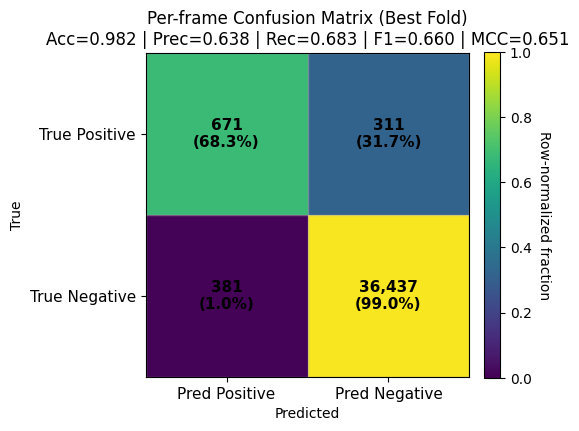

In [19]:
# =========================
# Per-frame inference + confusion matrix + MCC
# =========================
import os, numpy as np, torch
import torch.nn.functional as F
from torch import amp
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, matthews_corrcoef
import matplotlib.pyplot as plt

# --- fallbacks if not already defined ---
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224
if 'TEST_PATHS' not in globals():
    TEST_DIR   = "D:/dataset/converted_classifier_npz_compact"
    TEST_SLICE = (255, 300)  # [start, end)
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(".npz")])[TEST_SLICE[0]:TEST_SLICE[1]]
    TEST_PATHS = [os.path.join(TEST_DIR, f) for f in test_files]

# If you ran K-fold, set MODEL_PATHS = [best_fold_path1, best_fold_path2, ...]
if 'MODEL_PATHS' not in globals():
    # fallback: single best model
    MODEL_PATHS = [BEST_MODEL_PATH] if 'BEST_MODEL_PATH' in globals() else [
        "D:/acouslic-ai-cse4622/saved_weights/best_frame_classifier_afra.pth"
    ]

# Per-frame decision threshold
THRESH_FRAME = BEST_THRESHOLD if 'BEST_THRESHOLD' in globals() else 0.5
BATCH_SIZE   = 128

def letterbox_to_square_tensor(x: torch.Tensor, size=IMAGE_SIZE) -> torch.Tensor:
    is_batched = (x.dim() == 4)
    if not is_batched: x = x.unsqueeze(0)
    _, _, H, W = x.shape
    s = max(H, W)
    pad_h = (s - H) // 2
    pad_w = (s - W) // 2
    x = F.pad(x, (pad_w, s - W - pad_w, pad_h, s - H - pad_h))
    x = F.interpolate(x, size=(size, size), mode="bilinear", align_corners=False)
    return x if is_batched else x.squeeze(0)

def load_binary_labels(npz_path):
    y = np.load(npz_path, mmap_mode="r")["label"].astype(np.int64)
    y[y == 2] = 1  # merge suboptimal into positive
    return y

# --- Load models for ensemble ---
def build_model():
    m = FrameClassifier(num_classes=2).to(DEVICE)
    m.eval()
    return m

def load_state(m, path):
    ckpt = torch.load(path, map_location=DEVICE)
    state = ckpt.get("model_state", ckpt)  # supports plain state_dict or full checkpoint
    m.load_state_dict(state)
    return m

MODELS = []
for p in MODEL_PATHS:
    m = build_model()
    load_state(m, p)
    MODELS.append(m)
print(f"[Per-frame] Using ensemble of {len(MODELS)} model(s). Threshold={THRESH_FRAME:.2f}")

@torch.no_grad()
def predict_probs_over_frames_ensemble(npz_path, models, batch_size=BATCH_SIZE):
    d = np.load(npz_path, mmap_mode="r")
    frames = d["image"]  # (T,H,W) uint8
    Tn = len(frames)
    probs = np.zeros(Tn, dtype=np.float32)
    off = 0
    while off < Tn:
        chunk = frames[off:off+batch_size]
        x = torch.from_numpy(chunk).unsqueeze(1).float() / 255.0      # (B,1,H,W) [0,1]
        x = letterbox_to_square_tensor(x, size=IMAGE_SIZE)            # (B,1,S,S)
        x = (x - 0.5) / 0.5                                           # [-1,1]
        x = x.to(DEVICE)
        # average model probabilities
        p_sum = None
        with amp.autocast(device_type="cuda", enabled=(DEVICE=="cuda")):
            for m in models:
                logits = m(x)
                p = torch.softmax(logits, dim=1)[:, 1]
                p_sum = p if p_sum is None else (p_sum + p)
        p_avg = (p_sum / len(models)).detach().cpu().numpy()
        probs[off:off+len(p_avg)] = p_avg
        off += len(p_avg)
    return probs

# --- Accumulate per-frame labels/preds across all test sweeps ---
y_true_all = []
y_pred_all = []
y_prob_all = []

print(f"\n[Per-frame] Evaluating {len(TEST_PATHS)} test sweeps...")
for pth in tqdm(TEST_PATHS):
    yt = load_binary_labels(pth)                         # (T,)
    pr = predict_probs_over_frames_ensemble(pth, MODELS) # (T,)
    yp = (pr >= THRESH_FRAME).astype(np.int64)

    y_true_all.append(yt)
    y_pred_all.append(yp)
    y_prob_all.append(pr)

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_prob_all = np.concatenate(y_prob_all, axis=0)

# --- Metrics ---
cm = confusion_matrix(y_true_all, y_pred_all, labels=[1, 0])  # rows: true [pos,neg], cols: pred [pos,neg]
prec, rec, f1, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average="binary", zero_division=0)
mcc = matthews_corrcoef(y_true_all, y_pred_all)
acc = (y_true_all == y_pred_all).mean()

print("\n====== Per-frame METRICS ======")
print(f"Frames: {len(y_true_all)} | Positives: {int(y_true_all.sum())} | Negatives: {int((1-y_true_all).sum())}")
print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  MCC={mcc:.4f}")
print("Confusion matrix (rows=true [pos,neg], cols=pred [pos,neg]):")
print(cm)

# --- Pretty confusion matrix: counts + row-normalized percentages ---
def plot_cm_pretty(cm, acc, prec, rec, f1, mcc,
                   class_names=('Positive','Negative'),
                   title='Per-frame Confusion Matrix'):
    cm = np.asarray(cm)
    # Row-normalize (each row sums to 1) → recall per class
    row_sum = cm.sum(axis=1, keepdims=True).clip(min=1)
    cm_norm = cm / row_sum

    fig, ax = plt.subplots(figsize=(5.5, 4.8))
    im = ax.imshow(cm_norm, vmin=0.0, vmax=1.0, interpolation='nearest')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Row-normalized fraction', rotation=270, labelpad=14)

    # Ticks & labels (order matches labels=[1,0] above)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels([f'Pred {c}' for c in class_names], fontsize=11)
    ax.set_yticklabels([f'True {c}' for c in class_names], fontsize=11)

    # Annotate each cell with count and percentage
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i, j]:,}\n({cm_norm[i, j]*100:.1f}%)",
                    ha='center', va='center', fontsize=11, fontweight='bold')

    # Make cells square + add a subtle grid
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 1.5); ax.set_ylim(1.5, -0.5)
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
    ax.grid(which='minor', linestyle='-', linewidth=1, alpha=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Title with metrics
    ax.set_title(
        f"{title}\nAcc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f} | MCC={mcc:.3f}",
        fontsize=12
    )
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

# Call it after you compute cm/metrics:
plot_cm_pretty(cm, acc, prec, rec, f1, mcc,
               class_names=('Positive','Negative'),
               title='Per-frame Confusion Matrix (Best Fold)')



[Per-frame] Using BEST fold model: D:/acouslic-ai-cse4622/saved_weights\frame_cls_fold3.pth
[Per-frame] Threshold = 0.87

[Per-frame] Evaluating 45 test sweeps...


100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


====== Per-frame METRICS ======
Frames: 37800 | Positives: 982 | Negatives: 36818
Accuracy=0.9648  Precision=0.4126  Recall=0.8360  F1=0.5525  MCC=0.5729
Confusion matrix (rows=true [pos,neg], cols=pred [pos,neg]):
[[  821   161]
 [ 1169 35649]]


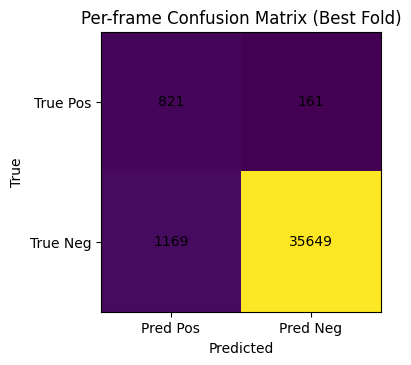

In [18]:
# =========================
# Per-frame inference (single best fold) + confusion matrix + MCC
# =========================
import os, numpy as np, torch
import torch.nn.functional as F
from torch import amp
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, matthews_corrcoef
import matplotlib.pyplot as plt

# ---- Config / fallbacks ----
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224
BATCH_SIZE = 128

# If TEST_PATHS wasn't built earlier, create it from your final test slice.
if 'TEST_PATHS' not in globals():
    TEST_DIR   = "D:/dataset/converted_classifier_npz_compact"
    TEST_SLICE = (255, 300)  # [start, end)
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.endswith(".npz")])[TEST_SLICE[0]:TEST_SLICE[1]]
    TEST_PATHS = [os.path.join(TEST_DIR, f) for f in test_files]

# Load best model path / threshold from CV if available; otherwise fallback
MODEL_PATH    = BEST_MODEL_PATH if 'BEST_MODEL_PATH' in globals() else \
                "D:/acouslic-ai-cse4622/saved_weights/best_frame_classifier_afra.pth"
THRESH_FRAME  = BEST_THRESHOLD  if 'BEST_THRESHOLD'  in globals() else 0.87

# ---- Utils (match training preprocessing) ----
def letterbox_to_square_tensor(x: torch.Tensor, size=IMAGE_SIZE) -> torch.Tensor:
    is_batched = (x.dim() == 4)
    if not is_batched: x = x.unsqueeze(0)
    _, _, H, W = x.shape
    s = max(H, W)
    pad_h = (s - H) // 2
    pad_w = (s - W) // 2
    x = F.pad(x, (pad_w, s - W - pad_w, pad_h, s - H - pad_h))
    x = F.interpolate(x, size=(size, size), mode="bilinear", align_corners=False)
    return x if is_batched else x.squeeze(0)

def load_binary_labels(npz_path):
    y = np.load(npz_path, mmap_mode="r")["label"].astype(np.int64)
    y[y == 2] = 1  # merge suboptimal into positive
    return y

# ---- Build & load model ----
model = FrameClassifier(num_classes=2).to(DEVICE)
ckpt  = torch.load(MODEL_PATH, map_location=DEVICE)
state = ckpt.get("model_state", ckpt)  # supports plain state_dict or full checkpoint
model.load_state_dict(state)
model.eval()

print(f"[Per-frame] Using BEST fold model: {MODEL_PATH}")
print(f"[Per-frame] Threshold = {THRESH_FRAME:.2f}")

@torch.no_grad()
def predict_probs_over_frames(npz_path, model, batch_size=BATCH_SIZE):
    d = np.load(npz_path, mmap_mode="r")
    frames = d["image"]  # (T,H,W) uint8
    Tn = len(frames)
    probs = np.zeros(Tn, dtype=np.float32)
    off = 0
    while off < Tn:
        chunk = frames[off:off+batch_size]
        x = torch.from_numpy(chunk).unsqueeze(1).float() / 255.0      # (B,1,H,W) [0,1]
        x = letterbox_to_square_tensor(x, size=IMAGE_SIZE)            # (B,1,S,S)
        x = (x - 0.5) / 0.5                                           # [-1,1]
        x = x.to(DEVICE)

        with amp.autocast(device_type="cuda", enabled=(DEVICE=="cuda")):
            logits = model(x)
            p = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        probs[off:off+len(p)] = p
        off += len(p)
    return probs

# ---- Accumulate per-frame labels/preds across all test sweeps ----
y_true_all, y_pred_all, y_prob_all = [], [], []

print(f"\n[Per-frame] Evaluating {len(TEST_PATHS)} test sweeps...")
for pth in tqdm(TEST_PATHS):
    yt = load_binary_labels(pth)         # (T,)
    pr = predict_probs_over_frames(pth, model)  # (T,)
    yp = (pr >= THRESH_FRAME).astype(np.int64)

    y_true_all.append(yt)
    y_pred_all.append(yp)
    y_prob_all.append(pr)

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_prob_all = np.concatenate(y_prob_all, axis=0)

# ---- Metrics ----
cm = confusion_matrix(y_true_all, y_pred_all, labels=[1, 0])  # rows: true [pos,neg], cols: pred [pos,neg]
prec, rec, f1, _ = precision_recall_fscore_support(y_true_all, y_pred_all, average="binary", zero_division=0)
mcc = matthews_corrcoef(y_true_all, y_pred_all)
acc = (y_true_all == y_pred_all).mean()

pos_count = int(y_true_all.sum())
neg_count = int((y_true_all == 0).sum())

print("\n====== Per-frame METRICS ======")
print(f"Frames: {len(y_true_all)} | Positives: {pos_count} | Negatives: {neg_count}")
print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  MCC={mcc:.4f}")
print("Confusion matrix (rows=true [pos,neg], cols=pred [pos,neg]):")
print(cm)

# ---- Confusion matrix plot ----
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(['Pred Pos', 'Pred Neg'])
ax.set_yticklabels(['True Pos', 'True Neg'])
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_title('Per-frame Confusion Matrix (Best Fold)')
for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()
